# 3. Perceptual Losses for Real-Time Style Transfer and Super-Resolution

* Autoren: Justin Johnson, Alexandre Alahi, Li Fei-Fei
* Erscheinungsdatum: 27.03.2016

Dieser Algorithmus besteht aus zwei wichtigen Schritten, dem Training und dem Style Tranfer. Das Training wird immer nur für ein Style-Image angewendet. Dazu benötigt man das COCO-2014-Train-images-Datenset (http://cocodataset.org/#home). Es werden zwei Neuronale Netze benutzt, das Image Transformation Network(auch fw oder style transform network genannt) und das Loss Network (VGG-16). Das vortrainierte VGG-16 Network wird gleich geladen, wie das VGG-19 bei Gatys et al. Während der Trainingsphase werden die Gewichte von VGG-16 nicht trainiert, allerdings die Gewichte des Image Transformation Network.Für das Training wird das COCO-Datenset und das gewünschte Style-Image verwendet. Nach dem Training ist das Image Transformation Network perfekt auf das Style-Image trainiert und man gibt das Content-Image durch das Image Transformation Network, um den Style-Transfer durchzuführen. Es wird dann nur noch eine Iteration benötigt.
<br>

<img src="jupyterbilder/jtraining.jpg">
<img src="jupyterbilder/jtransfer.jpg">


Dadurch das nach dem Training nur noch eine Iteration nötig ist, geht der eigentliche Style Transfer deutlich schneller, als bei Gayts et al. vor allem bei hoher Auflösung der Bilder. Die Spalte "Ours" in der folgenden Tabelle zeigen die Werte des Johnson et al. Algorithmus. Es wurde für 100,300 und 500 Iterationen verglichen und auf einer GTX Titan X GPU durchgeführt.

<img src="jupyterbilder/jtable.jpg">

Quelle Bild: [2]Seite 12, Table 1


Der folgende Code wurde auf Basis des Papers <br>
[2] Justin Johnson, Alexandre Alahi, Li Fei-Fei. "Perceptual Losses for Real-Time Style Transfer and Super-Resolution." arXiv:1603.08155v1 (2016)<br>
selbst implementiert.

### Code:

In [ ]:
#Getestet mit Python /home/uo002/.direnv/python-3.6.8rc1/lib/python3.6/

#Testen ob tensorflow und keras funktionieren
try:
    import keras
    import tensorflow as tf
    from tensorflow.python.client import device_lib
except:
    print("Fehler beim Keras-TF laden")
    sys.exit(-1)
    
tf_version = tf.__version__

if (tf_version != "1.10.0"):
    print(str(tf_version) + " ist falsche TF Version")
else:
    print("TF Version " + tf_version)
    
keras_version = keras.__version__
if (keras_version != "2.2.4"):
    print(str(keras_version) + " ist falsche Keras Version. 2.2.4 wird benötigt")
else:
    print("Keras Version " + keras_version)

In [1]:
#GPU auf JARVIS
import os
jarvis_gpu = 2
os.environ["CUDA_VISIBLE_DEVICES"] = str(jarvis_gpu)
print("Reserviere GPU: " + str(os.environ["CUDA_VISIBLE_DEVICES"]))

from tensorflow.python.client import device_lib
try:
    devices = device_lib.list_local_devices()
    gpu_bekommen = False
    for dev in devices:
        if str(dev).find("GPU"):
            gpu_bekommen = True

    if gpu_bekommen == False:
        print("Fehler beim reservieren der GPU " + str(jarvis_gpu))
        sys.exit(0)
    else:
        print("Jarvis GPU " + str(jarvis_gpu) + " erfolgreich reserviert")
        print("---------------------")
except:
        print("Fehler beim reservieren der GPU " + str(jarvis_gpu))
        quit()

Reserviere GPU: 2
Jarvis GPU 2 erfolgreich reserviert
---------------------


In [2]:
from keras import layers
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.layers import Lambda
from tensorflow.python.keras.preprocessing import image as K_image
import keras.backend as K
from keras.applications import vgg16
import keras
import tensorflow as tf
from keras.layers import UpSampling2D, Activation, Lambda, Conv2D, Input, Add, BatchNormalization
from keras.models import Model


import sys
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import scipy.misc
from PIL import Image
import functools
import time
import numpy as np
import time
import pickle
import h5py
from copy import deepcopy
import time

Using TensorFlow backend.


In [3]:
width = 256
height = 256
image_dim  = (width,height,3)
vgg_mean   = np.array([103.939, 116.779, 123.68]).astype('uint8') #für VGG-16

#Hyperparameter
content_output_layer = ["block3_conv3"] #relevante Layer für Content
style_output_layer   = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3"] #relevante Layer für den Style
#siehe [2]Seite 9 "...we computefeature reconstruction loss at layer relu2_2 and style reconstruction loss  
#at layers relu1_2, relu2_2, relu3_3, and relu4_3 of the VGG-16 loss network..."
#Gatys et al. benutzt andere Layer


lambdac  = [ 1000.0 ] #Gewichtung Content (bei Gatys et al. ist die Gewichtung anders)
lambdas  = [ 1.0 ] #Gewichtung Style (bei Gatys et al. ist die Gewichtung anders)


#Training Parameter
#Anzahl der Bilder im Training Loop
#Wenn man zwei Epochen trainieren will, muss "training_images" doppelt so hoch sein wie "coco_images"
training_images = 40000
#Anzahl der Bilder, die geladen werden sollen. Werden im Training Loop wiederholt, wenn coco_images<training_images
#coco_images darf nicht größer als 20.000 sein, sonst passt das geladene Array nicht in den RAM von JARVIS
#Lösung: die ersten 20.000 Bilder laden -> Training, dann die nächsten 20.000 laden -> Training
coco_images     = 20000

learning_rate   = 0.001
batch_size      = 4
always_train    = True
#siehe [2]Seite 9 "...style transfer networks are trained on the MicrosoftCOCO dataset. We resize each of 
#the 80k training images to 256×256 and train our networks with a batch size of 4 for 40,000 iterations ... We use Adam
#with a learning rate of 1×10−3..."

In [4]:
#Lädt Bild und bereitet es für VGG16 vor

def load_image(pfad, width=width, height=height):
    image = Image.open(pfad)
    image = image.convert(mode="RGB")
    image = image.resize((width, height), Image.ANTIALIAS)
    image = K_image.img_to_array(image)
    image = np.expand_dims(image, axis=0) #fügt eine 1 als Länge der ersten Dimension an, 1=Anzahl der Daten (batch)
    image = vgg16.preprocess_input(image) #bereitet Bild für VGG16 optimal vor
    return image


In [5]:
#wird verwendet um Bilder im Jupyter Notebook anzuzeigen (kein preprocess_input)

def load_image2(pfad):
    image = Image.open(pfad)
    image = image.convert(mode="RGB")
    image = image.resize((image_dim[1],image_dim[0]), Image.ANTIALIAS)
    image = K_image.img_to_array(image)
    image = np.clip(image, 0, 255).astype('uint8') #damit Werte der Pixel zwischen 0 und 255 sind
    return image

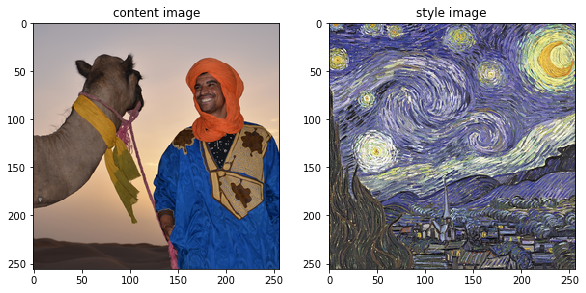

In [6]:
StyleImage   = "jupyterbilder/svangogh2.jpg"
ContentImage = "jupyterbilder/ccamel.jpg"

contentbild  = load_image2(ContentImage)
stylebild    = load_image2(StyleImage)

plt.figure(1,figsize=(15,15))
plt.subplot(131)
plt.title("content image")
plt.imshow(contentbild)

plt.subplot(132)
plt.title("style image")
plt.imshow(stylebild)

plt.show()

 ## 3.1. Image Transform Net erstellen

Der Aufbau des Netzes ist genau im supplementary material beschrieben. <br>
Aufbau des Image Transform Net:
<img src="jupyterbilder/fw.jpg">

Aufbau Residual Block (Abbildung rechts wird für den Aufbau der residual Layers verwendet):
<img src="jupyterbilder/res.jpg">

Quelle beide Bilder: Perceptual Losses for Real-Time Style Transferand Super-Resolution: Supplementary Material

In [7]:
#Berechnet Padding
def pad_size(x):
    return int( (x - 1) / 2 )

#baut den residual Block
def res(X_in, filters=128, name=""):
    p = pad_size(3)
    X = Conv2D(filters, (3, 3), strides=(1, 1))(X_in)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)
    X = Conv2D(filters, (3, 3), strides=(1, 1))(X)
    X = BatchNormalization(axis=3)(X)
    
    return X

def fw_nn(width=width, height=width):
    ####################
    # LAYER 0
    #####################
    X_in = Input(shape=(width, height, 3))

    ####################
    # LAYER 1
    #####################
    X = Lambda(lambda x: tf.pad(x, [[0, 0], [40, 40], [40, 40], [0, 0]], "REFLECT"))(X_in)

    ####################
    # LAYER 2
    #####################
    k = 9
    p = pad_size(k)
    # In [2] wird kein Hinweis gegeben, wie Padding gemacht werden muss.
    # Aufgrund der Layergrößen in der Tabelle im supplementary material ist klar, dass entweder SAME oder REFLECTION Padding
    # verwendet werden muss. Reflection Padding gibt die besseren Ergebnisse.
    X = Lambda(lambda x: tf.pad(x, [[0,0], [p,p], [p,p], [0,0]], "REFLECT"))(X)
    X = Conv2D(32, (k, k), strides=(1, 1))(X)

    # BatchNormalization hat nicht richtig funktioniert. Ergebnis schwarzes Bild im Test-Modus.--> BatchNormalization kann nur im Trainings-Modus verwendet werden
    X = BatchNormalization(axis=3)(X)

    X = Activation("relu")(X)

    ####################
    # LAYER 3
    #####################
    k = 3
    p = pad_size(k)
    X = Lambda(lambda x: tf.pad(x, [[0,0], [p,p], [p,p], [0,0]], "REFLECT"))(X)
    X = Conv2D(64, (k, k), strides=(2, 2))(X)
    X = BatchNormalization(axis=3)(X)

    X = Activation("relu")(X)

    #####################
    # LAYER 4
    #####################
    k = 3
    p = pad_size(k)
    X = Lambda(lambda x: tf.pad(x, [[0,0], [p,p], [p,p], [0,0]], "REFLECT"))(X)
    X = Conv2D(128, (k, k), strides=(2, 2))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)

    ############################
    # LAYER 5 : Residual Block 1
    ############################
    X = res(X)

    ############################
    # LAYER 6 : Residual Block 2
    ############################
    X = res(X)

    ############################
    # LAYER 7 : Residual Block 3
    ############################
    X = res(X)

    ############################
    # LAYER 8 : Residual Block 4
    ############################
    X = res(X)

    ############################
    # LAYER 9 : Residual Block 5
    ############################
    X = res(X)

    ############################
    # LAYER 10 : Upsampling 1
    ############################
    # Fractionally strided convolution
    # https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0
    X = UpSampling2D()(X)
    k = 3
    p = pad_size(k)
    X = Lambda(lambda x: tf.pad(x, [[0,0], [p,p], [p,p], [0,0]], "REFLECT"))(X)
    X = Conv2D(64, (k, k), strides=(1, 1))(X)
    X = BatchNormalization(axis=3)(X)

    X = Activation("relu")(X)


    ############################
    # LAYER 11 : Upsampling 2
    ############################
    X = UpSampling2D()(X)
    k = 3
    p = pad_size(k)
    X = Lambda(lambda x: tf.pad(x, [[0,0], [p,p], [p,p], [0,0]], "REFLECT"))(X)
    X = Conv2D(32, (k, k), strides=(1, 1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)

    ############################
    # LAYER 12
    ############################
    #Letzter Layer ohne Relu, dafür mit tanh
    k = 9
    p = pad_size(k)
    X = Lambda(lambda x: tf.pad(x, [[0,0], [p,p], [p,p], [0,0]], "REFLECT"))(X)
    X = Conv2D(3, (k, k), strides=(1, 1))(X)
    X = BatchNormalization(axis=3)(X)

    # " All non-residual convolutional layers are followed by spatial batch normalization [45] and ReLU nonlinearities
    # with the exception of the output layer, which instead uses a scaled tanh to ensure that the output image has
    # pixels in the range [0; 255]." [2] Seite 5
    X = Activation("tanh")(X)
    X = Lambda(lambda x: 128*x)(X)

    #Keras model
    nn = Model(inputs = X_in, outputs = X)
    return nn


 ## 3.2. Loss Network (VGG16) laden
 
 Bei Gatys et al. wird VGG19 geladen, VGG16 ist fast identisch, außer weniger tief (19>16).
 Auch hier werden die Fully-Connected-Layer nicht geladen und das Netz wurde mit "ImageNet" trainiert. <br>
 __siehe__ [2]Seite 6 "...16-layer VGG network pretrained on the ImageNet dataset." <br>
 <br>
 Die Features werden von den oben benannten Layern benötigt und in Dictionaries (phi_yc und phi_ys) abgespeichert.
 Außerdem wird der Output von dem Image Transformation Net __y_hat__ durch VGG16 geschickt. Da man nur einen Input Tensor angeben kann, muss __y_hat__ in einem extra Schritt durch VGG16 geschickt werden.
 
Style Target wird hier erstmal nicht berücksichtigt, weil diese Features Konstanten sind und diese werden weiter unten erzeugt. Sie müssen nur einmalig erzeugt werden.
 
 <img src="jupyterbilder/fig2.jpg">
 
 
 Quelle: [2]Seite 4

In [8]:
#y_hat = kommt aus fw (Image Transform Net)
#y_c = Bild von COCO-Datenset


def lossNetwork(y_hat=None, y_c=None):
    with tf.variable_scope('lossNetwork'):
        vgg16input_dim = image_dim
        vgg16 = keras.applications.vgg16.VGG16(include_top=False,
                                               input_tensor=y_c,
                                               weights='imagenet'
                                               )
        for layer in vgg16.layers:
            layer.trainable = False

        phi_yc = {}
        for layer in content_output_layer:
            phi_yc[layer] = vgg16.get_layer(layer).output

        phi_ys = {}
        for layer in style_output_layer:
            phi_ys[layer] = vgg16.get_layer(layer).output

        # y_hat durch vgg16 schicken
        phi_yhat = {}
        X = y_hat
        for layer in vgg16.layers[1:]: #layer 0 nicht
            X = layer(X)
            phi_yhat[layer.name] = X

        return vgg16, phi_yhat, phi_yc, phi_ys

Der "Trick" besteht darin, "y_c = image_transform_nn.input" zu setzen, weil das COCO-Bild sowohl in das 
Image Transform Net, als auch durch das Loss Net geschickt werden muss. Y_hat ist der Output vom Image Transform Net 
und wird hier mir dem Loss Net verbunden.

In [9]:
#Neural Networks
image_transform_nn = fw_nn()
print("Image Transform Net:")
image_transform_nn.summary()



loss_nn, phi_yhat, phi_yc, phi_ys = lossNetwork(y_hat=image_transform_nn.output, y_c=image_transform_nn.input)
print("#"*70)
print("Loss Net:")
loss_nn.summary()

Image Transform Net:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 336, 336, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 344, 344, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 336, 336, 32)      7808      
_________________________________________________________________
batch_normalization_1 (Batch (None, 336, 336, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 336, 336, 32)      0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 338, 338, 32)      

 ## 3.3. Content Loss
 
Die Formel ist fast identisch zu Gatys et al. Der einzige Unterschied ist die Normalisierung, hier wird durch den Term
1/C*H*W normalisiert, bei Gatys et al. durch 1/2. Die Formel ist auf Seite 7 unter (2) zu finden. Phi_yhat ist der Output von Image Transform Net, wurde durch VGG16 geschickt und die Features als Dictionary gespeichert. In Phiy sind die Content-Features des jeweiligen COCO-Bild (ebenfalls durch VGG16 geschickt) gespeichert.

In [10]:
#phi_yhat = generated_features, Output von Image Transform Net
#phiy = content_features, von COCO Bilder



def loss_content(phi_yhat, phiy):
    with tf.variable_scope('lossContent'):
        lc = 0.0
        for name in content_output_layer:
            m, dH, dW, dC = phiy[name].shape 
            norm = dH * dW * dC
            norm = float(int(norm))
            lc = lc + tf.multiply(1 / (norm), tf.reduce_sum(tf.square(tf.subtract(phi_yhat[name], phiy[name]))))
        return lc

 ## 3.4. Gram-Matrix
 
Hier werden die Gram-Matrizen erstellt. Außerdem wird hier normiert mit (1/chw) , das ist ein Unterschied zu Gatys et al., dort wird bei der Gram-Matrix nicht normiert.<br>
__siehe__ [2]Seite 7 Formel (3)<br>
Mit der Funktion "def style_gramm" werden die Gram-Matrizen für das Style-Image erzeugt, das ist quasi eine "Konstante" und wird hier als  __G_ys__ bezeichnet und ist ein Dictionary das die Gram-Matrizen des Style-Images enthält.

In [11]:
#Gram-Matrix Berechnung

def grammatrix(R):
    with tf.variable_scope("GramMatrix"):

        # https://pgaleone.eu/tensorflow/2018/07/28/understanding-tensorflow-tensors-shape-static-dynamic/
        s = tf.shape(R)
        m, h, w, c = s[0], s[1], s[2], s[3]

        # Trick von Andrew Ng, nur diesmal auf 4 Dimensionen anstatt auf 3
        # Erzeugt einen 1-D Tensor aus shape Parametern des Eingangs:
        # Wenn x.shape=[5,256,256,3]  --> b = [5,3,256*256]
        R = tf.transpose(R, perm=[0, 3, 2, 1])
        # concat ist nötig, damit aus Tensoren eine Liste wird, nur dann funktioniert reshape
        b = tf.concat([[m], [c], [h*w]], 0)
        reshaped  = tf.reshape(R, b)        
        reshapedT = tf.transpose(reshaped, [0,2,1])
        gm        = tf.matmul(reshaped, reshapedT)
        gmt = tf.constant(1, dtype=tf.float32) / (tf.cast(c*h*w, tf.float32)) * gm
        #print("gmt shape ", gmt)

        return gmt

In [12]:
#Gram-Matrizen von Style Bild
def style_gramm(styleBild):
    style = load_image(styleBild)
    

    gl_style = [] #enthält dann Tensoren (Knoten im DAG) der Gram-Matrizen
    for name in style_output_layer:
        gl_style.append(grammatrix(phi_ys[name]))
    
    # nötig, da nur Tensoren (Knoten im DAG) gespeichert sind
    #wird durch Loss Net geschickt
    forward_propagation = K.function([loss_nn.input], gl_style) #ähnlich wie Model bei Keras
    output = forward_propagation([style]) #hier wird es ausgeführt vgl. predict bei Keras

    # name = key, layer = value
    G_ys = {name: layer for name, layer in zip(style_output_layer, output)}

    return G_ys


G_ys = style_gramm(StyleImage)

 ## 3.5. Style Loss
 
Diese Formel ist auf Seite 8 unter (4) zu finden. <br>
Auch bei dieser Formel ist die Normierung anders als bei Gatys et al. Die Normierung bei Gatys et al. ist (1.0 / (4 *(N**2 * M**2 ), wobei __N__ und __M__ die Breite und Höhe des Outputs von VGG19 beschreiben. Hier wird nicht normiert, weil das bei der Gram-Matrix gemacht wird.<br>
__G_ys__ ist ein Dictionary das die Gram-Matritzen des Style-Images enthält (wurde oben erstellt).<br>
__siehe__  [2] Seite 8 "The style reconstruction loss is then the squared Frobenius norm of the difference between the Gram matrices of the output and target images..."

In [13]:
def loss_style(phi_yhat, G_ys, style_output_layer):

    ls = []

    with tf.variable_scope('lossStyle'):
        for lay in style_output_layer:
            gram_a = grammatrix(phi_yhat[lay])
            gram_b = G_ys[lay]

            print("Gram Matrix Größe:" + str(gram_b.shape) )
            c, h, w = gram_b.shape

            layerloss = tf.reduce_sum(tf.square(tf.subtract(gram_a , gram_b)), (1, 2))

            ls.append(layerloss)
        return ls

 ## 3.6. Total Loss
 
Auch hier wird wie bei Gatys et al. der Content loss und der Style loss addiert mit den beiden Hyperparametern, die für die Gewichtung zuständig sind.<br> In __ls__ wird eine Liste mit den Style-losses der vier Layer gespeichert.

In [14]:
def loss_total(phi_yhat, G_ys ):
    with tf.variable_scope('lossTotal'):
        ls = loss_style(phi_yhat, G_ys, style_output_layer)

        lt = tf.Variable(0.0, dtype=tf.float32)
        for lossstyle in ls:
            lt = lt + tf.reduce_mean(lambdas * lossstyle) #Mittelwert über batch
            #lt = lt + lambdas * lossstyle

        lt = lt + lambdac * loss_content(phi_yhat, phi_yc)

        return lt

 ## 3.7. COCO-Dataset für Training vorbereiten
 
In diesem Schritt wird das COCO-Datenset aus dem Verzeichnis geladen und für das Training vorbereitet. Die Bilder werden für VGG16 vorverarbeitet und dann in X_Train (array) gespeichert. Das geladene Training-Set X_Train wird außerdem in einer Datei (h5-Format) gespeichert, um den aufwändigen Einlese- und Vorprozessierschritt für das nächstmalige Trainieren zu verkürzen. Es können nicht mehr als 20k Bilder in einem Schritt geladen werden, da es dann Probleme mit dem RAM von JARVIS entstehen. Deshalb darf __m__ nicht größer als 20.000 sein. Wenn man die nächsten 20k Bilder von COCO laden will setzt man __start__ auf 1.

In [15]:
import skimage.io as io
import skimage
from skimage.transform import rescale, resize
import os
from pathlib import Path

#m = wieviel Bilder sollen geladen werden
#start = sollen die ersten oder die zweiten ... 20k Bilder geladen werden
#0-20k, 20k-40k, 40k-60k, 60k-80k als eigene h5-files. Ansonsten gibt es Probleme mit dem RAM.

def read_coco(m, path = "coco/train2014", start=0):

    coco_filename = "coco" + str(m) + "_" + str(start) + "_" + str(width) +".h5"
    start_index   = m * start
    end_index     = m * (start+1)
    
    all_images    = []
    coco_file = Path(coco_filename) #aus filename wird Pfad gemacht
    if coco_file.is_file(): # prüft ob es die Datei schon gibt
        print(coco_filename + " gefunden. Lade Bilddaten.")
        with h5py.File(coco_filename, "r") as all_images_ds: #r steht für read
            all_images = np.array(all_images_ds["coco"]) 
            
        
    else:
        coco_list  = os.listdir(path)
        #size       = len(coco_list) - start_index
        assert end_index < len(coco_list), "Falscher Parameter für Start"
        all_images = np.zeros((m,width,height,3))
        print("Länge der Coco Liste ", len(coco_list))

        #jedes Bild wird gelesen und verarbeitet (für VGG16 vorbereitet)
        for i,image_path in enumerate(coco_list[start_index:end_index]):
            img = io.imread(path + "/" + image_path)
            img = skimage.color.grey2rgb(img)
            img = resize(img,(width,height))*256
            img = img.astype(int)

            img = vgg16.preprocess_input(img)


            all_images[i]=img
            if i% 100 == 0:
                print(str(i) + " Bilder aus " + str(path) +" geladen. Index " + str(start_index+i))  

        with h5py.File(coco_filename, "w") as all_images_ds: #w steht für write
                all_images_ds.create_dataset("coco" , data=all_images)
                
    return all_images

#so viele Bilder werden aus dem COCO-Dataset für das Training geladen.
#0-20k, 20k-40k, 40k-60k, 60k-80k als eigene h5-files. Ansonsten gibt es Probleme mit dem RAM.
# Deshaob darf coco_images darf nicht größer als 20.000 sein
 
X_train = read_coco(coco_images, start=0)

print("X_train.shape:  ",X_train.shape)
print("Erstes Bild shape:  ",X_train[0].shape)


coco20000_0_256.h5 gefunden. Lade Bilddaten.
X_train.shape:   (20000, 256, 256, 3)
Erstes Bild shape:   (256, 256, 3)


## 3.8. Training
Erst wird überprüft, ob das Neuronale Netz schon für das gewünschte Style Image trainiert wurden, in dem Fall werden dann die bereits trainierten Gewichte geladen (über eine h5-Datei). Das Training wird über die Kerasfunktion __K.function__ realisiert. Als Optimierungsfuntion wird "Adam" verwendet. <br>

__siehe__ [2]Seite 9: "We use Adam with a learning rate of 1×10−3..."<br>
 
Quelle über Umgang mit K.function: https://gist.github.com/bstriner/e1e011652b297d13b3ac3f99fd11b2bc

In [16]:
# Training Loop
from keras.optimizers import Adam

#eindeutiger Name wird gebildet, damit es nicht nochmal trainert, falls es schon trainiert hat
itnn_filename = StyleImage.split("/")[-1] + ".ImageTransferNN.h5"
itnn_file = Path(itnn_filename)

# es wurde schon für genau dieses Style-Image trainiert -> es werden also nur noch die Gewichte geladen
# always_train = true, wenn getestet wird -> es soll also immer trainiert werden soll (Test-, Ausprobierphase) 
if itnn_file.is_file() and always_train==False:
    ImageTransformNN.load_weights(itnn_file) #load_weights kommt aus Library und lädt die Gewichte
    print("Weights für dieses Style Image wurden schon trainiert")
    print("Weights für " + StyleImage + " in ImageTransformNN geladen")
else:
    # Content Loss und Style Loss
    losstotal = loss_total(phi_yhat, G_ys)
    
    print("Starte mit Training")
    # Training mit K.function von Keras: Jede Forward Propagation wird extra aufgerufen
    # Quelle: https://towardsdatascience.com/https-medium-com-manishchablani-useful-keras-features-4bac0724734c
    # https://gist.github.com/bstriner/e1e011652b297d13b3ac3f99fd11b2bc
    # vgl. .compile und .fit
    ins          = [image_transform_nn.input, K.learning_phase()]
    adam         = Adam(lr=learning_rate)
    upd          = adam.get_updates(params=image_transform_nn.trainable_weights, loss=losstotal)
    outs         = [losstotal]
    forward_prop = K.function(ins, outs, upd)
    
    loss_history  = [] #wird benötigt für bokeh (Loss wird hier gespeichert)

    # hier wird die batch-size richtig verarbeitet, in dem Fall 4, damit immer die batch-size geladen wird
    start = time.time()#Zeitmessung
    for i in range(0, training_images , batch_size):
        b_start = i % coco_images
        b_end = min(b_start + batch_size + 1, len(X_train))
        batch = X_train[b_start:b_end]

        #Übergibt "batch" als input des NN und 1.0 als K.learning_phase -> Training
        #batch wird auf den Tensor input geschoben und 1.0 wird auf Tensor K.learning_phase() geschoben
        #1.0 bedeutet, dass Keras lernen soll, nur dann werden Gewichte upgedatet
        # forward_prop gibt den Loss zurück
        l = forward_prop([batch, 1.0]) 
        loss_history.append(l[0][0])
        if i % 100 == 0:
            print("Training image ", i, ", Coco image: ", b_start, "-", b_end - 1, ", Total Loss: ", l[0])
            
    end = time.time()
    print()
    print("############################################################")
    print()
    print("Zeit in Sekunden (Training): ",end - start)

       
    if always_train==False:
        ImageTransformNN.save_weights(itnn_filename)
    print("Weights für " + StyleImage + " gespeichert als " + itnn_filename)    

Gram Matrix Größe:(1, 64, 64)
Gram Matrix Größe:(1, 128, 128)
Gram Matrix Größe:(1, 256, 256)
Gram Matrix Größe:(1, 512, 512)
Starte mit Training
Training image  0 , Coco image:  0 - 4 , Total Loss:  [3.2925214e+11]
Training image  100 , Coco image:  100 - 104 , Total Loss:  [1.6783496e+10]
Training image  200 , Coco image:  200 - 204 , Total Loss:  [1.9204405e+10]
Training image  300 , Coco image:  300 - 304 , Total Loss:  [1.6431358e+10]
Training image  400 , Coco image:  400 - 404 , Total Loss:  [1.148686e+10]
Training image  500 , Coco image:  500 - 504 , Total Loss:  [9.881613e+09]
Training image  600 , Coco image:  600 - 604 , Total Loss:  [7.485524e+09]
Training image  700 , Coco image:  700 - 704 , Total Loss:  [5.6099287e+09]
Training image  800 , Coco image:  800 - 804 , Total Loss:  [4.636286e+09]
Training image  900 , Coco image:  900 - 904 , Total Loss:  [4.749725e+09]
Training image  1000 , Coco image:  1000 - 1004 , Total Loss:  [5.0078653e+09]
Training image  1100 , Coc

Training image  10300 , Coco image:  10300 - 10304 , Total Loss:  [2.1283834e+09]
Training image  10400 , Coco image:  10400 - 10404 , Total Loss:  [2.453148e+09]
Training image  10500 , Coco image:  10500 - 10504 , Total Loss:  [2.1669757e+09]
Training image  10600 , Coco image:  10600 - 10604 , Total Loss:  [2.1634565e+09]
Training image  10700 , Coco image:  10700 - 10704 , Total Loss:  [2.385726e+09]
Training image  10800 , Coco image:  10800 - 10804 , Total Loss:  [2.4993055e+09]
Training image  10900 , Coco image:  10900 - 10904 , Total Loss:  [2.9046738e+09]
Training image  11000 , Coco image:  11000 - 11004 , Total Loss:  [2.1131113e+09]
Training image  11100 , Coco image:  11100 - 11104 , Total Loss:  [2.2412529e+09]
Training image  11200 , Coco image:  11200 - 11204 , Total Loss:  [2.3635702e+09]
Training image  11300 , Coco image:  11300 - 11304 , Total Loss:  [2.1921329e+09]
Training image  11400 , Coco image:  11400 - 11404 , Total Loss:  [2.5341046e+09]
Training image  11

Training image  20400 , Coco image:  400 - 404 , Total Loss:  [1.8129869e+09]
Training image  20500 , Coco image:  500 - 504 , Total Loss:  [1.8044129e+09]
Training image  20600 , Coco image:  600 - 604 , Total Loss:  [1.8651492e+09]
Training image  20700 , Coco image:  700 - 704 , Total Loss:  [2.041026e+09]
Training image  20800 , Coco image:  800 - 804 , Total Loss:  [1.6779187e+09]
Training image  20900 , Coco image:  900 - 904 , Total Loss:  [1.9048714e+09]
Training image  21000 , Coco image:  1000 - 1004 , Total Loss:  [2.0142446e+09]
Training image  21100 , Coco image:  1100 - 1104 , Total Loss:  [1.8542249e+09]
Training image  21200 , Coco image:  1200 - 1204 , Total Loss:  [1.887267e+09]
Training image  21300 , Coco image:  1300 - 1304 , Total Loss:  [2.0157806e+09]
Training image  21400 , Coco image:  1400 - 1404 , Total Loss:  [1.8958348e+09]
Training image  21500 , Coco image:  1500 - 1504 , Total Loss:  [1.6860984e+09]
Training image  21600 , Coco image:  1600 - 1604 , Tot

Training image  30700 , Coco image:  10700 - 10704 , Total Loss:  [1.6707781e+09]
Training image  30800 , Coco image:  10800 - 10804 , Total Loss:  [1.8511628e+09]
Training image  30900 , Coco image:  10900 - 10904 , Total Loss:  [2.3012383e+09]
Training image  31000 , Coco image:  11000 - 11004 , Total Loss:  [1.5936607e+09]
Training image  31100 , Coco image:  11100 - 11104 , Total Loss:  [1.678811e+09]
Training image  31200 , Coco image:  11200 - 11204 , Total Loss:  [1.7604088e+09]
Training image  31300 , Coco image:  11300 - 11304 , Total Loss:  [1.6535972e+09]
Training image  31400 , Coco image:  11400 - 11404 , Total Loss:  [1.8661096e+09]
Training image  31500 , Coco image:  11500 - 11504 , Total Loss:  [1.7183377e+09]
Training image  31600 , Coco image:  11600 - 11604 , Total Loss:  [1.9483587e+09]
Training image  31700 , Coco image:  11700 - 11704 , Total Loss:  [1.6044302e+09]
Training image  31800 , Coco image:  11800 - 11804 , Total Loss:  [1.7265946e+09]
Training image  3

## 3.9. Style Transfer und Anzeige von Ergebnis
 
Hier wird der Style Transfer mit nur einer Iteration durchegführt. __"forward_propagation_nach_Training"__ wird nur einmal aufgerufen. Das Content Image wird übergeben und davor mit der Funktion __load_image__ für Keras vorbereitet.  __K.function__ wird kein Update mehr mitgegeben, aber es wird definiert welches Neuroanle Netz benutzt werden soll.

In [21]:
content       = load_image(ContentImage)


contentshow   = load_image2(ContentImage)
styleshow     = load_image2(StyleImage)


# Hier wird der Style_Transfer durchgeführt
# K.function wird kein Update mitgegeben, nur input und output
# forward_propagation_nach_Training wird nur einmal aufgerufen -> eine Iteration

start = time.time()#Zeitmessung
forward_propagation_nach_Training = K.function([image_transform_nn.input, K.learning_phase()],[image_transform_nn.output])
generatedImage = forward_propagation_nach_Training([content,1.0])
end = time.time()
print("Zeit in Sekunden (Style Transfer): ",end - start)

gi = np.array(generatedImage[0][0]) 

gi[:, :, 0] += vgg_mean[0] #r
gi[:, :, 1] += vgg_mean[1] #g
gi[:, :, 2] += vgg_mean[2] #b
gi = gi[:, :, ::-1]
gi = np.clip(gi, 0, 255).astype('uint8')

plt.figure(1,figsize=(15,15))
plt.subplot(131)
plt.title("content image")
plt.imshow(contentshow)

plt.subplot(132)
plt.title("style image")
plt.imshow(styleshow)

plt.subplot(133)
plt.title("generated image")
plt.imshow(gi)



Zeit in Sekunden (Style Transfer):  0.19214630126953125


<img src="jupyterbilder/200000bilder.jpg">

In [41]:
import bokeh
from bokeh.io import show,output_notebook
from bokeh.plotting import figure, output_file, ColumnDataSource
output_notebook()

iarray = [i for i in range(int(training_images/batch_size))]

p = figure(plot_width=600, plot_height=400,title="Loss-Funktionen")
p.xaxis.axis_label = 'Iteration'
p.yaxis.axis_label = 'Loss'
p.line(iarray,loss_history, legend="Totalloss",line_width=2)

show(p)


Loading BokehJS ...

## weitere verwendete Resourcen


http://cocodataset.org/#download

https://arxiv.org/pdf/1603.08155.pdf

https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16Supplementary.pdf

https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/datasets/coco.py

https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0

<img src="jupyterbilder/jzeitmessung.jpg">
<img src="jupyterbilder/jgesicht.jpg">
<img src="jupyterbilder/jstyle.jpg">
<img src="jupyterbilder/jallgemein.jpg">